In [1]:
!pip install gensim

In [2]:
!pip install wordcloud

In [3]:
!pip install spacy

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import spacy
import nltk
import tensorflow as tf
import gensim
from gensim.models import Word2Vec
import unicodedata
from collections import Counter
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from tensorflow import keras
from keras import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding,LSTM,Dense,Dropout
from keras.callbacks import ReduceLROnPlateau,EarlyStopping
from keras.optimizers import Adam
from wordcloud import WordCloud
nlp = spacy.load("en_core_web_sm")
import seaborn as sns
import re
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import confusion_matrix,classification_report
import zipfile
import os
plt.style.use('ggplot')
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

2024-08-12 17:32:20.130048: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-12 17:32:20.130165: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-12 17:32:20.252103: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
!python -m spacy download en_core_web_sm


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 61.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [6]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/


mv: cannot stat 'kaggle.json': No such file or directory


In [7]:
columns=['target','id','date','flag','user','tweets']
df=pd.read_csv('/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv',encoding='ISO-8859-1',header=None)
df.columns=columns

In [8]:
df.head()

,target,id,date,flag,user,tweets
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   id      1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   tweets  1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [10]:
#check missing values
df.isnull().sum()

target    0
id        0
date      0
flag      0
user      0
tweets    0
dtype: int64

In [11]:
#check for duplicates
df.duplicated().sum()

0

In [12]:
df.describe()

,target,id
count,1.600000e+06,1.600000e+06
mean,2.000000e+00,1.998818e+09
std,2.000001e+00,1.935761e+08
min,0.000000e+00,1.467810e+09
25%,0.000000e+00,1.956916e+09
50%,2.000000e+00,2.002102e+09
75%,4.000000e+00,2.177059e+09
max,4.000000e+00,2.329206e+09


In [13]:
df['target'].value_counts()

target
0    800000
4    800000
Name: count, dtype: int64

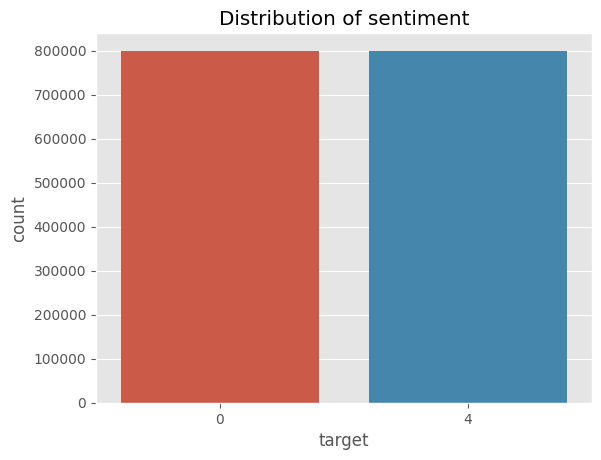

In [14]:
sns.countplot(data=df,x='target')
plt.title('Distribution of sentiment')
plt.show()


In [15]:
hashs=df['tweets'].apply(lambda x:re.findall('#[a-zA-Z]+',x))

flattened_hashs = [tag for sublist in hashs for tag in sublist]

# Join the flattened list into a single string, separated by spaces
hashtags_string = ' '.join(flattened_hashs)



In [16]:
hashcounter=Counter(hashtags_string.split())
top10=hashcounter.most_common(10)
top10

[('#followfriday', 2114),
 ('#fb', 1747),
 ('#squarespace', 888),
 ('#FF', 588),
 ('#seb', 499),
 ('#FollowFriday', 463),
 ('#musicmonday', 405),
 ('#ff', 399),
 ('#iranelection', 360),
 ('#fail', 301)]

In [17]:
tophash=pd.DataFrame(top10,columns=['hashtag','count'])

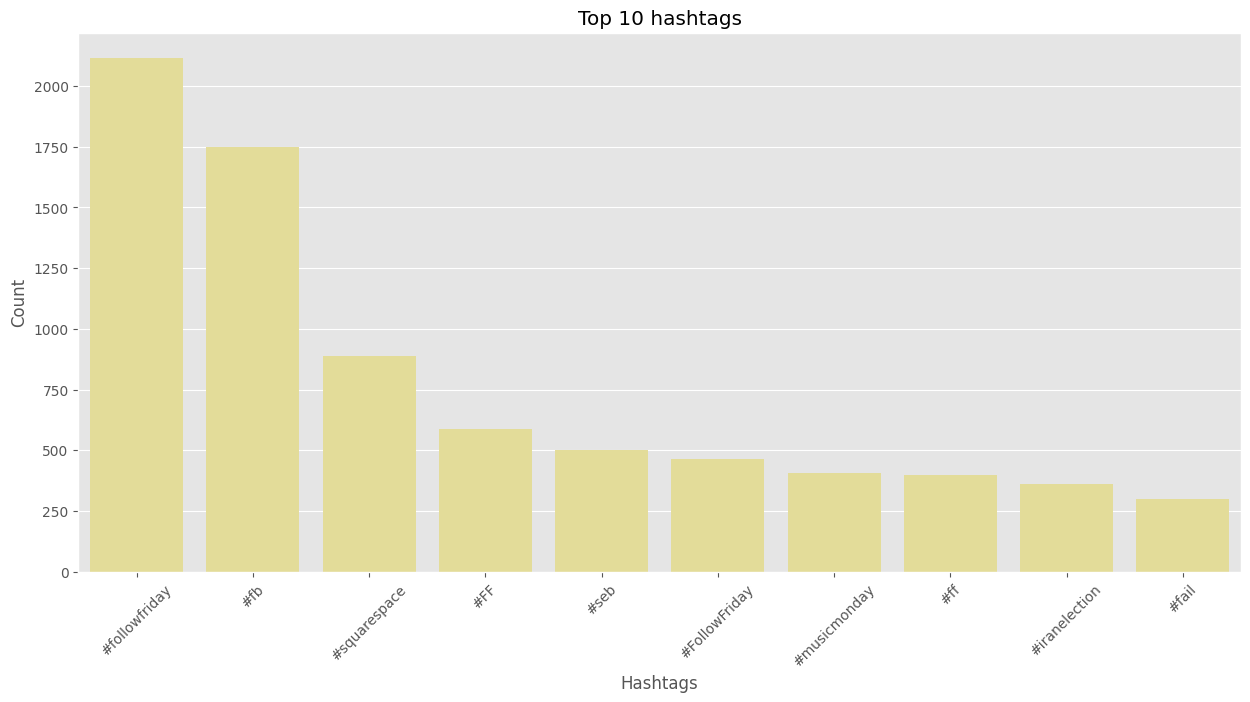

In [18]:
colors = ['#FF5733', '#33FF57', '#3357FF', '#F0E68C', '#8A2BE2', '#FF4500', '#2E8B57', '#20B2AA', '#FFD700', '#FF6347']
plt.figure(figsize=(15,7))
sns.barplot(data=tophash,x='hashtag',y='count',color=colors[3])
plt.xlabel('Hashtags')
plt.ylabel('Count')
plt.title('Top 10 hashtags')
plt.xticks(rotation=45 )
plt.show()

In [19]:
df['chars_count']=df['tweets'].apply(lambda x:len(x))
df['words_count']=df['tweets'].apply(lambda x:len(x.split()))

In [20]:
stop_words=set(stopwords.words('english'))

In [21]:
df['stop_words_count']=df['tweets'].apply(lambda x:sum(1 for word in x.split() if word.lower() in stop_words))
df['stop_words']=df['tweets'].apply(lambda x: [word for word in x.split() if word.lower() in stop_words])

In [22]:
df['mention_count']=df['tweets'].apply(lambda x:sum(1 for w in x.split() if '@' in w))
df['hashtag_count']=df['tweets'].apply(lambda x:sum(1 for w in x.split() if '#' in w))

In [23]:
df

,target,id,date,flag,user,tweets,chars_count,words_count,stop_words_count,stop_words,mention_count,hashtag_count
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",115,19,5,"[a, You, of, to, do]",1,0
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,111,21,8,"[is, that, he, his, by, and, as, a]",0,0
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,89,18,7,"[I, for, the, to, The, out, of]",1,0
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,47,10,4,"[my, and, its, on]",0,0
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",111,21,11,"[it's, not, at, why, am, i, because, I, you, a...",1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...,56,11,5,"[Just, Having, no, is, the]",0,0
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...,78,11,2,"[Very, to]",0,0
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...,57,11,6,"[Are, you, for, your, me, for]",0,0
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...,65,12,3,"[to, my, of]",0,0


In [24]:
url_pattern = re.compile(r'https?://(?:www\.)?\S+(?:/|\b)')
df['url_count']=df['tweets'].apply(lambda x:len(re.findall(url_pattern,x)))

In [25]:
df['digits_count']=df['tweets'].apply(lambda x: sum(1 for w in x.split() if w.isdigit()))

In [26]:
pattern='[a-zA-Z0-9]+@[a-zA-Z0-9]+\.[a-zA-Z]+'
df['email_count']=df['tweets'].apply(lambda x:len([w for w in x.split() if re.match(pattern,w)]))


In [27]:
df['clean_tweets']=df['tweets'].apply(lambda x:' '.join([word for word in x.split() if word.lower() not in stop_words]))


In [28]:
def remove_pattern(pattern,text):
  r=re.findall(pattern,text)
  for i in r:
    text=re.sub(i,'',text)
  return text

In [29]:
#remove mentions
df['clean_tweets']=df['clean_tweets'].apply(lambda x:remove_pattern('@[a-zA-Z]+',x))

#remove hashtags
df['clean_tweets']=df['clean_tweets'].apply(lambda x:remove_pattern('#[a-zA-Z]+',x))

#remove space
df['clean_tweets']=df['clean_tweets'].apply(lambda x:x.strip())

In [30]:
# Function to normalize accented characters
def remove_accents(text):
    # Normalize the text to NFKD form
    normalized_text = unicodedata.normalize('NFKD', text)
    # Filter out combining characters (accents)
    return ''.join([c for c in normalized_text if not unicodedata.combining(c)])

In [31]:
df['clean_tweets'] = df['clean_tweets'].apply(remove_accents)

In [32]:
df['clean_tweets'] = df['clean_tweets'].apply(lambda x:re.sub(r"https?://(?:www\.)?[^\s/$.?#].[^\s]*",'',x))

In [33]:
def remove_non_alphanumeric(text):
    return re.sub(r'[^a-zA-Z0-9\s]', '', text)

In [34]:
df['clean_tweets'] = df['clean_tweets'].apply(lambda x:remove_non_alphanumeric(x))
df['clean_tweets']=df['clean_tweets'].str.strip()
df['clean_tweets']=df['clean_tweets'].str.lower()

In [35]:
def lemetize(doc):
  filtered_tokens=[]
  for token in doc:
     filtered_tokens.append(token.lemma_)
  return ' '.join(filtered_tokens)

#### Take sample from data

In [36]:
df0=df[df['target']==0].sample(20000,random_state=42)
df4=df[df['target']==4].sample(20000,random_state=42)
X=pd.concat([df0,df4]).reset_index(drop=True)

In [37]:
X

,target,id,date,flag,user,tweets,chars_count,words_count,stop_words_count,stop_words,mention_count,hashtag_count,url_count,digits_count,email_count,clean_tweets
0,0,1974671194,Sat May 30 13:36:31 PDT 2009,NO_QUERY,simba98,@xnausikaax oh no! where did u order from? tha...,59,10,2,"[where, did]",1,0,0,0,0,oh no u order from thats horrible
1,0,1997882236,Mon Jun 01 17:37:11 PDT 2009,NO_QUERY,Seve76,A great hard training weekend is over. a coup...,121,25,11,"[A, is, a, of, and, do, it, of, to, in, now]",0,0,0,0,0,great hard training weekend over couple days r...
2,0,2177756662,Mon Jun 15 06:39:05 PDT 2009,NO_QUERY,x__claireyy__x,"Right, off to work Only 5 hours to go until I...",56,13,5,"[off, to, Only, to, until]",0,0,0,1,0,right work 5 hours go im free xd
3,0,2216838047,Wed Jun 17 20:02:12 PDT 2009,NO_QUERY,Balasi,I am craving for japanese food,31,6,3,"[I, am, for]",0,0,0,0,0,craving japanese food
4,0,1880666283,Fri May 22 02:03:31 PDT 2009,NO_QUERY,djrickdawson,Jean Michel Jarre concert tomorrow gotta work...,65,10,1,[before],0,0,0,0,0,jean michel jarre concert tomorrow gotta work ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,4,2015425445,Wed Jun 03 04:37:52 PDT 2009,NO_QUERY,JBnVFCLover786,LOL MY BUSINESS or MY WORK ACTUALLY (totally ...,65,11,3,"[MY, or, MY]",0,0,0,0,0,lol business work actually totally inside joke...
39996,4,2014642083,Wed Jun 03 02:12:15 PDT 2009,NO_QUERY,TerriEddyAlice,Sims 3 is amazing to tell you all!,35,8,3,"[is, to, you]",0,0,0,1,0,sims 3 amazing tell all
39997,4,2068855838,Sun Jun 07 14:49:25 PDT 2009,NO_QUERY,dougggie,@jodiekearns we splashed out on an awning a fe...,87,16,9,"[we, out, on, an, a, few, but, not, very]",1,0,0,0,0,splashed awning years ago great portable
39998,4,1973828077,Sat May 30 11:54:51 PDT 2009,NO_QUERY,e_anne,I HAVE A NEW CAR! ... it is in Florida.,41,10,6,"[I, HAVE, A, it, is, in]",0,0,0,0,0,new car florida


In [38]:
X['clean_tweets']=X['clean_tweets'].apply(lambda x:lemetize(nlp(x)))

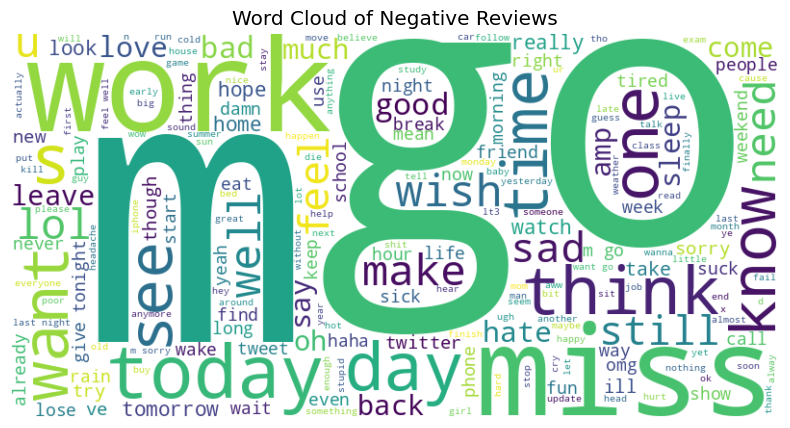

In [39]:
negative_reviews = X[X['target'] ==0]['clean_tweets'].str.cat(sep=' ')

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Negative Reviews')
plt.show()

#### Word Cloud For positive reviews

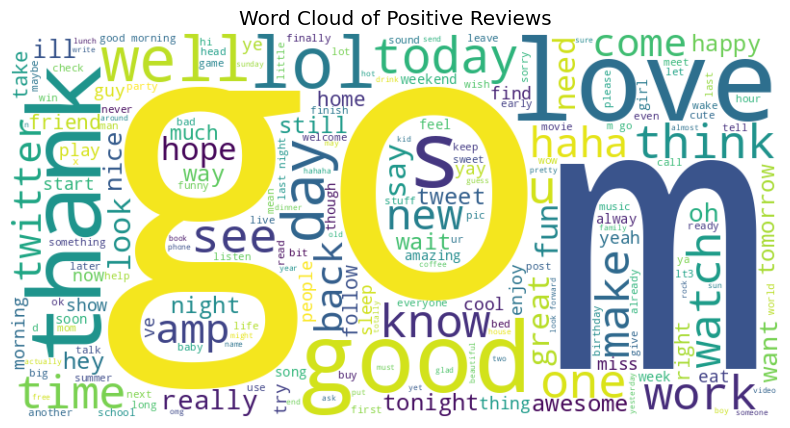

In [40]:
positive_reviews = X[X['target'] ==4]['clean_tweets'].str.cat(sep=' ')
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Positive Reviews')
plt.show()

In [41]:
x=X['clean_tweets']
y=X['target'].replace({4:1})
y.shape

(40000,)

In [42]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [43]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((32000,), (8000,), (32000,), (8000,))

#### let’s use TFidf vectorizer

In [44]:
Tfidf=TfidfVectorizer(max_features=5000,ngram_range=(1,2))
x_train=Tfidf.fit_transform(x_train).toarray()
x_test=Tfidf.transform(x_test).toarray()

In [45]:
NB_model = MultinomialNB()
NB_model.fit(x_train, y_train)

MultinomialNB()

In [46]:
# Get prediction
y_pred = NB_model.predict(x_test)

In [47]:
# Print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.74      0.74      4014
           1       0.74      0.74      0.74      3986

    accuracy                           0.74      8000
   macro avg       0.74      0.74      0.74      8000
weighted avg       0.74      0.74      0.74      8000



In [48]:
rf=RandomForestClassifier()
rf.fit(x_train,y_train)

RandomForestClassifier()

In [49]:
rf.score(x_train,y_train)

0.9870625

In [50]:
y_pred=rf.predict(x_test)

In [51]:
# Print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.73      0.73      4014
           1       0.73      0.73      0.73      3986

    accuracy                           0.73      8000
   macro avg       0.73      0.73      0.73      8000
weighted avg       0.73      0.73      0.73      8000



In [52]:
print(confusion_matrix(y_pred,y_test))

[[2921 1082]
 [1093 2904]]


#### XGBoost

In [53]:
y_train = np.where(y_train == 4, 1, y_train)
y_test = np.where(y_test == 4, 1, y_test)

In [54]:
xg=XGBClassifier()
xg.fit(x_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [55]:
y_pred=xg.predict(x_test)

In [56]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.76      0.65      0.70      4014
           1       0.69      0.79      0.74      3986

    accuracy                           0.72      8000
   macro avg       0.72      0.72      0.72      8000
weighted avg       0.72      0.72      0.72      8000



In [57]:
print(confusion_matrix(y_test,y_pred))

[[2606 1408]
 [ 833 3153]]


#### use word2vec

In [58]:
#convert text to list
listfeatures=df['clean_tweets'].tolist()
#convert each sequance to list
x=[i.split() for i in listfeatures]
y=df['target'].replace({4:1})
y.value_counts()

target
0    800000
1    800000
Name: count, dtype: int64

In [59]:
dim=100
word2vec=Word2Vec(sentences=x,vector_size=dim,min_count=1,window=5)
word2vec.wv['love'].shape

(100,)

#### use tokenize method

In [60]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(x)

In [61]:
x=tokenizer.texts_to_sequences(x)


In [62]:
len(x)

1600000

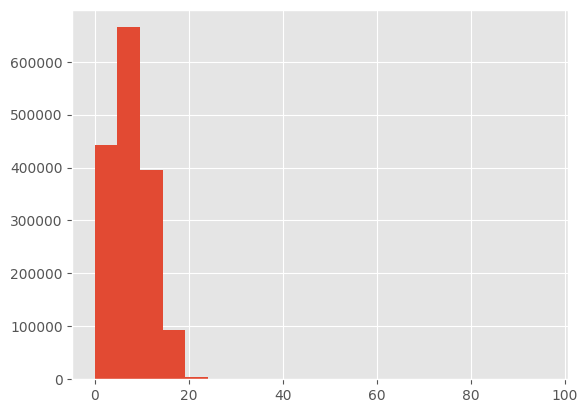

In [63]:
plt.hist([len(w) for w in x],bins=20)
plt.show()

In [64]:
#check number of words that their length >20 words
nos=np.array([len(w) for w in x])
len(nos[nos>20])

2226

In [65]:
mxlen=30
x=pad_sequences(x,maxlen=mxlen)

In [66]:
#vocab size per token
vocab_size=len(tokenizer.word_index)+1
vocabs=tokenizer.word_index
vocab_size

459512

In [67]:
# create weight matrix to store vectores generated from gnesim
def get_weight_matrix(model):
  weight_matrix=np.zeros((vocab_size,dim))
  for word,i in vocabs.items():
      weight_matrix[i]=word2vec.wv[word]
  return weight_matrix
embedding_vectors=get_weight_matrix(word2vec)
embedding_vectors.shape

(459512, 100)

In [68]:
model=Sequential()
model.add(Embedding(vocab_size,output_dim=dim,weights=[embedding_vectors],input_length=mxlen,trainable=False))
model.add(LSTM(128,return_sequences=True))
model.add(LSTM(128))
model.add(Dense(64,activation='relu'))
#model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [69]:
model.build(input_shape=(None, mxlen))

In [70]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 30, 100)        │    45,951,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 30, 128)        │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,208,353 (176.27 MB)

 Trainable params: 257,153 (1004.50 KB)

 Non-trainable params: 45,951,200 (175.29 MB)

In [71]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [72]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [73]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2,mode='min')
erly=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True,mode='min')

history=model.fit(x_train,y_train,epochs=30,validation_split=0.2,batch_size=64,callbacks=[lr_scheduler,erly])

Epoch 1/30
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 128s 8ms/step - accuracy: 0.7632 - loss: 0.4835 - val_accuracy: 0.7899 - val_loss: 0.4431 - learning_rate: 0.0010
Epoch 2/30
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 123s 8ms/step - accuracy: 0.7959 - loss: 0.4332 - val_accuracy: 0.7915 - val_loss: 0.4409 - learning_rate: 0.0010
Epoch 3/30
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 123s 8ms/step - accuracy: 0.8045 - loss: 0.4183 - val_accuracy: 0.7956 - val_loss: 0.4335 - learning_rate: 0.0010
Epoch 4/30
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 122s 8ms/step - accuracy: 0.8114 - loss: 0.4063 - val_accuracy: 0.7960 - val_loss: 0.4342 - learning_rate: 0.0010
Epoch 5/30
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 122s 8ms/step - accuracy: 0.8163 - loss: 0.3963 - val_accuracy: 0.7948 - val_loss: 0.4389 - learning_rate: 0.0010
Epoch 6/30
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 122s 8ms/step - accuracy: 0.8293 - loss: 0.3725 - val_accuracy: 0.7950 - val_loss: 0.4447 - learning_rate: 1.0000e-04


In [74]:
model.evaluate(x_test,y_test)

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 36s 4ms/step - accuracy: 0.7963 - loss: 0.4329


[0.4334443211555481, 0.7962218523025513]

In [75]:
model.evaluate(x_train,y_train)

40000/40000 ━━━━━━━━━━━━━━━━━━━━ 141s 4ms/step - accuracy: 0.8130 - loss: 0.4039


[0.4095306694507599, 0.8096148371696472]

In [76]:
y_pred=model.predict(x_test)
y_pred=np.where(y_pred>0.5,1,0)

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step


In [77]:
print(confusion_matrix(y_test,y_pred))

[[126144  33350]
 [ 31859 128647]]


In [78]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.80      0.79      0.79    159494
           1       0.79      0.80      0.80    160506

    accuracy                           0.80    320000
   macro avg       0.80      0.80      0.80    320000
weighted avg       0.80      0.80      0.80    320000



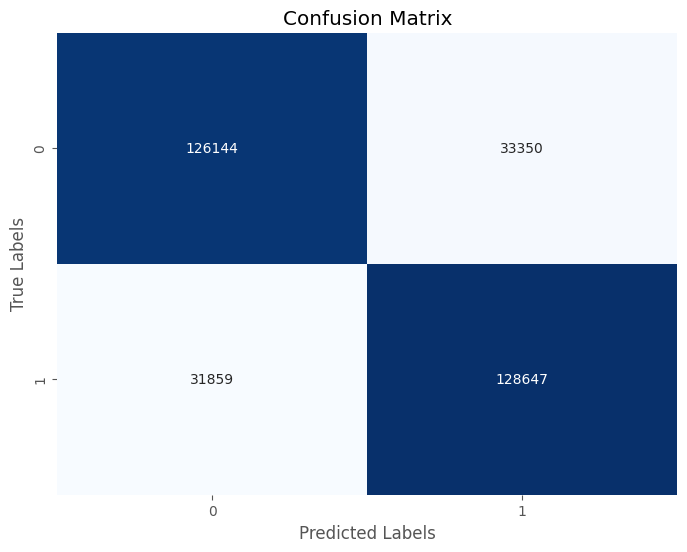

In [79]:
conf=confusion_matrix(y_test,y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf, annot=True, fmt='d', cmap='Blues', cbar=False)

# Add labels and title for clarity
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [80]:
def predictions(text):
    txt=text
    text=tokenizer.texts_to_sequences(text)
    text=pad_sequences(text,maxlen=mxlen)
    y_pred=model.predict(text)
    y_pred=np.where(y_pred>0.5,1,0)
    if y_pred[0] == 0:
        print(txt)
        print(y_pred[0])
        print('Negative')
    else:
        print(txt)
        print(y_pred[0])
        print('Positive')
        
predictions(df['clean_tweets'].sample(n=1))        

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
693975    looking good karate test
Name: clean_tweets, dtype: object
[1]
Positive
